Upload gambar buram:


Saving seq_id-2 frame-8 Input.png to seq_id-2 frame-8 Input (2).png


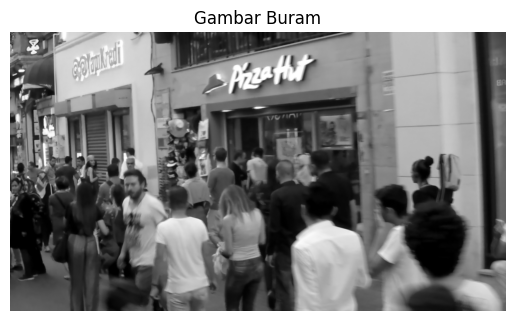

In [ ]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Upload gambar buram
print("Upload gambar buram:")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Baca gambar grayscale
blurred = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if blurred is None:
    raise FileNotFoundError("Gambar buram tidak ditemukan.")

plt.imshow(blurred, cmap='gray')
plt.title("Gambar Buram")
plt.axis('off')
plt.show()


In [ ]:
from scipy.signal import convolve2d

def lucy_richardson_deblur(image, psf, iterations=30):
    image = image.astype(np.float64) / 255.0
    psf_mirror = psf[::-1, ::-1]
    estimate = np.full(image.shape, 0.5)
    for _ in range(iterations):
        conv = convolve2d(estimate, psf, 'same')
        relative_blur = image / (conv + 1e-7)
        estimate *= convolve2d(relative_blur, psf_mirror, 'same')
    estimate = np.clip(estimate, 0, 1)
    return (estimate * 255).astype(np.uint8)


In [ ]:
def wiener_filter(img, kernel, K=0.01):
    # FFT gambar dan kernel
    img_float = np.float32(img) / 255.0
    kernel_padded = np.zeros_like(img_float)
    kh, kw = kernel.shape
    kernel_padded[:kh, :kw] = kernel

    dft_img = cv2.dft(img_float, flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_kernel = cv2.dft(kernel_padded, flags=cv2.DFT_COMPLEX_OUTPUT)

    # Wiener filter
    dft_kernel_conj = dft_kernel.copy()
    dft_kernel_conj[:,:,1] *= -1

    denom = dft_kernel[:,:,0]**2 + dft_kernel[:,:,1]**2 + K

    real = (dft_kernel_conj[:,:,0] * dft_img[:,:,0] + dft_kernel_conj[:,:,1] * dft_img[:,:,1]) / denom
    imag = (dft_kernel_conj[:,:,0] * dft_img[:,:,1] - dft_kernel_conj[:,:,1] * dft_img[:,:,0]) / denom

    dft_result = np.zeros_like(dft_img)
    dft_result[:,:,0] = real
    dft_result[:,:,1] = imag

    img_restored = cv2.idft(dft_result, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
    img_restored = np.clip(img_restored, 0, 1)
    img_restored = (img_restored * 255).astype(np.uint8)
    return img_restored


PSNR Lucy-Richardson: 18.65 dB
PSNR Wiener Filter: 16.02 dB


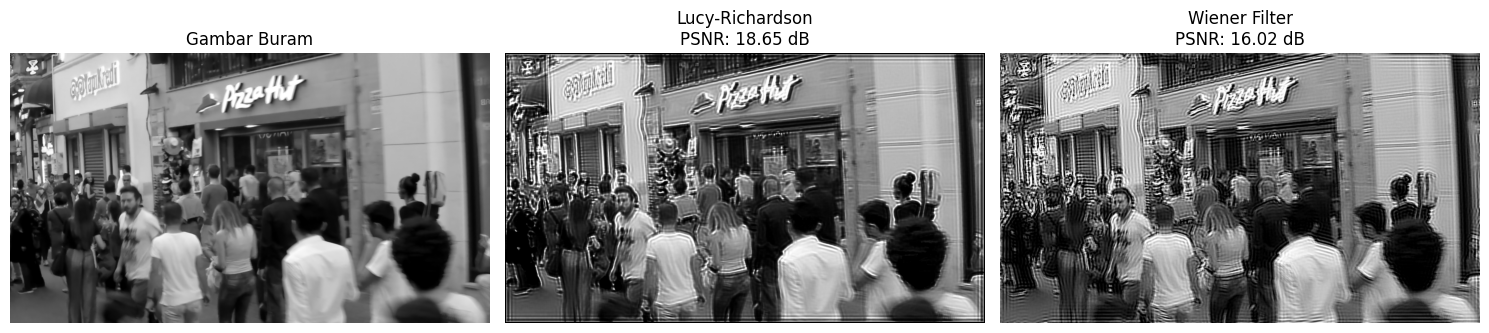

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr

# Kernel PSF (misal box blur)
kernel_size = 9
kernel = np.ones((kernel_size, kernel_size)) / (kernel_size ** 2)

# Deblur dengan Lucy-Richardson
deblurred_lr = lucy_richardson_deblur(blurred, kernel, iterations=30)

# Deblur dengan Wiener Filter
deblurred_wiener = wiener_filter(blurred, kernel, K=0.01)

# Karena kita tidak punya ground truth,
# PSNR kita hitung dari hasil deblur terhadap gambar buram sebagai pembanding kasar
psnr_lr = psnr(blurred, deblurred_lr)
psnr_wiener = psnr(blurred, deblurred_wiener)

print(f"PSNR Lucy-Richardson: {psnr_lr:.2f} dB")
print(f"PSNR Wiener Filter: {psnr_wiener:.2f} dB")

# Tampilkan hasil
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Gambar Buram")
plt.imshow(blurred, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title(f"Lucy-Richardson\nPSNR: {psnr_lr:.2f} dB")
plt.imshow(deblurred_lr, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title(f"Wiener Filter\nPSNR: {psnr_wiener:.2f} dB")
plt.imshow(deblurred_wiener, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
